# Final Project: NYC Taxi Traffic Analysis

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import numpy as np
import plotly.io as pio
import seaborn as sns
pio.renderers.default = 'notebook'

## Introduction

In this culminating project, our goal is to utilize unsupervised anomaly detection methods to analyze NYC Taxi Traffic Data. We will experiment with various anomaly detection techniques and evaluate their effectiveness. Additionally, we will discuss the significance of our findings and their potential applications.

Anomaly detection is a technique used in machine learning and data mining to identify unusual or unexpected patterns in data. It helps to identify outliers and their underlying causes, which can improve decision making and prevent fraudulent activities.

## Data Explorer

The dataset contains information about the number of passengers in NYC taxis, with five notable anomalies occurring during the NYC Marathon, Thanksgiving, Christmas, New Year's Day, and a snowstorm. The data is sourced from the NYC Taxi and Limousine Commission and is presented in aggregated form, with the total number of passengers grouped into 30-minute intervals. This information can be used to understand how events and weather patterns impact taxi usage in the city.

In [3]:
df = pd.read_csv("/kaggle/input/nyc-taxi-traffic/dataset.csv",parse_dates = ['timestamp'],index_col=0)
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 241.9 KB


In [4]:
df = df.set_index('timestamp')
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


We try to make some visualization of this dataset:

1. The original data consists of time series data with 30-minute intervals. 
2. As the anomaly points occur on a daily basis, we conducted a Seasonal Decomposition analysis based on days.
3. The plots for weekdays and weekends show noticeable differences, with traffic being significantly higher at 0 hour during weekends. 

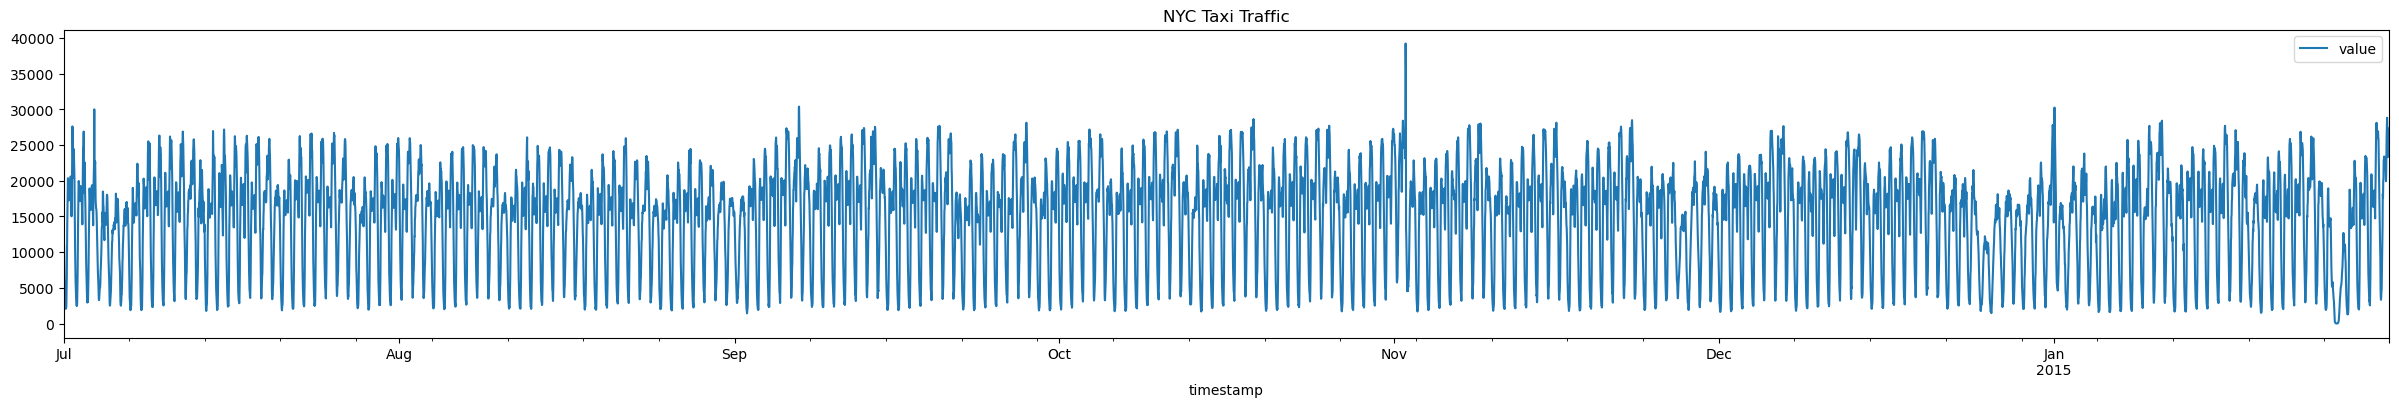

In [5]:
df.plot(title='NYC Taxi Traffic', figsize=(30,4))
plt.show()

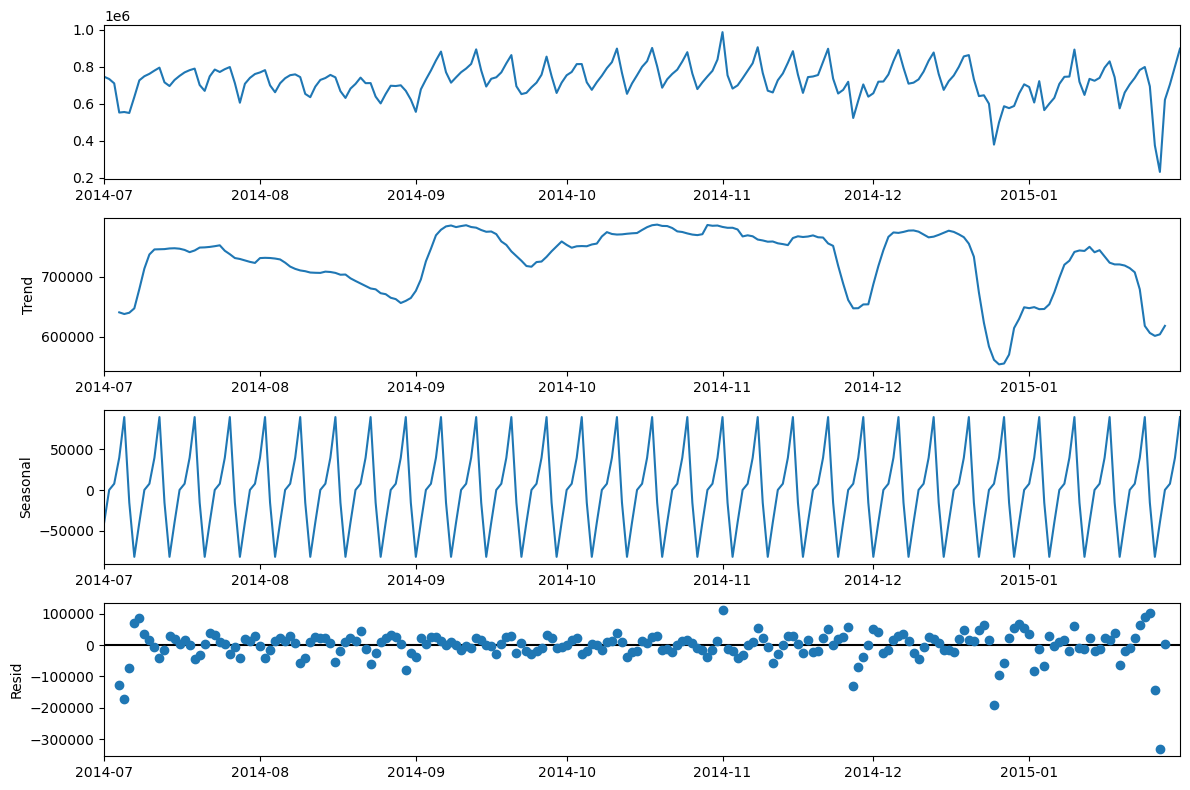

In [6]:
data_hourly = df.resample('D').sum()
result = seasonal_decompose(data_hourly, model='additive')

plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

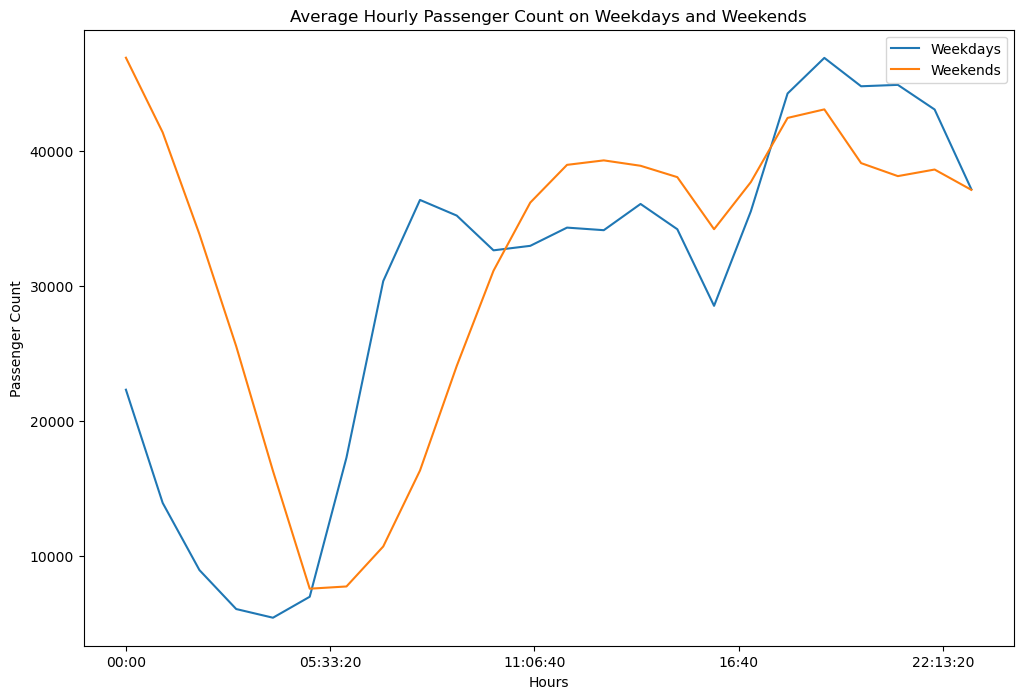

In [7]:
hourly_data = df.resample('H').sum()

weekday_data = hourly_data[hourly_data.index.weekday < 5].groupby(hourly_data[hourly_data.index.weekday < 5].index.time).mean()
weekend_data = hourly_data[hourly_data.index.weekday >= 5].groupby(hourly_data[hourly_data.index.weekday >= 5].index.time).mean()

plt.figure(figsize=(12,8))
plt.plot(weekday_data.index, weekday_data.values, label='Weekdays')
plt.plot(weekend_data.index, weekend_data.values, label='Weekends')
plt.xlabel('Hours')
plt.ylabel('Passenger Count')
plt.title('Average Hourly Passenger Count on Weekdays and Weekends')
plt.legend()
plt.show()

## Anomaly Detection with Unsupervised Methods

We use LSTM Autoencoder Method to perform the unsupervised anomaly detection. 

LSTM autoencoder is a type of neural network architecture that is specifically designed to learn and compress sequential data, such as time series data, while also being able to reconstruct the original data from the compressed representation. The Long Short-Term Memory (LSTM) units in the network allow it to effectively capture long-term dependencies in the input data, making it suitable for tasks such as anomaly detection and data compression. 


### Split datset

We split data into train set and test set:

1. TRAINING DATASET:  from  2014-07-01 00:00:00  to  2014-10-16 11:30:00
Data size:  5160
Number of days:  107
2. TESTING DATASET:  from  2014-10-16 12:00:00  to  2015-01-31 23:30:00
Data size:  5160
Number of days:  107

In [8]:
ratio = 0.5
train_size = int(df.shape[0] * ratio)
train = df[:train_size]
test = df[train_size:]

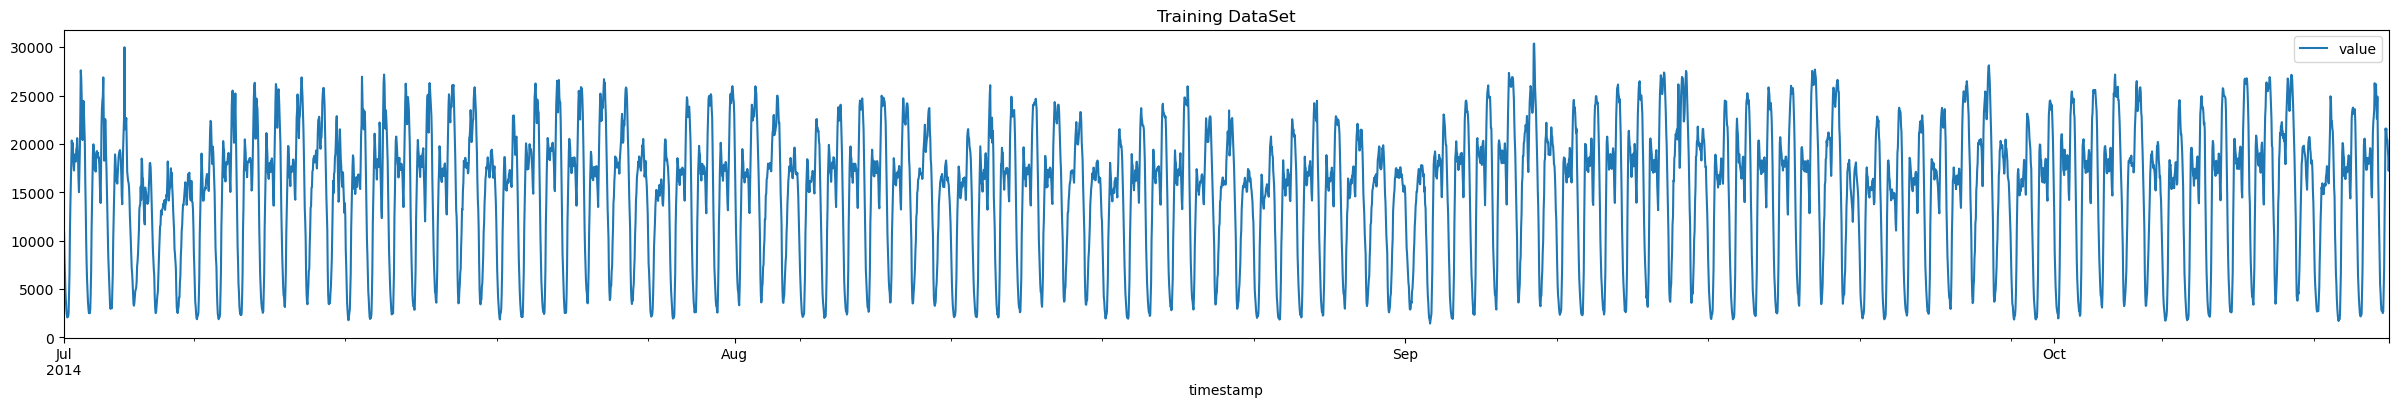

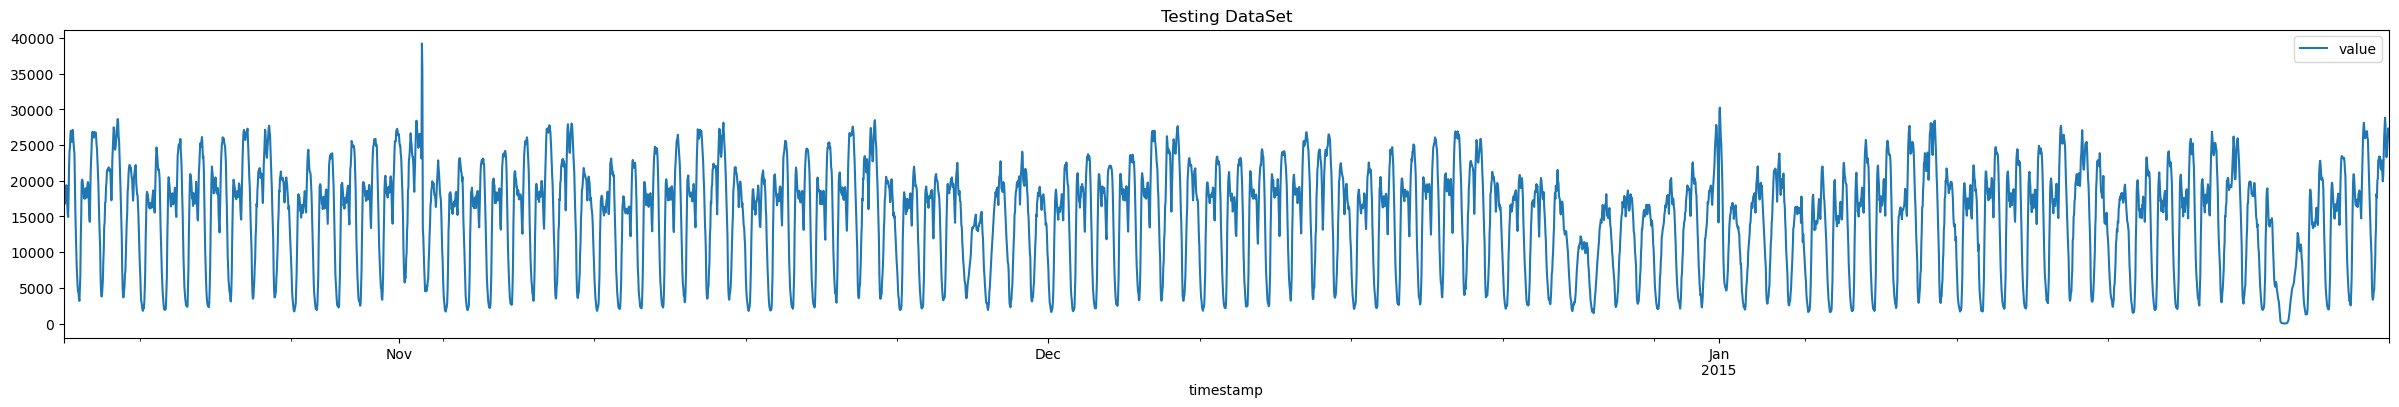

In [9]:
train.plot(title='Training DataSet', figsize=(30,4))
plt.show()

test.plot(title='Testing DataSet', figsize=(30,4))
plt.show()

### Data standardization

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(train.values)
train = scaler.transform(train.values)
test = scaler.transform(test.values)

### Window Sliding on Time Series

To capture features in Time Series data, we use a window sliding method to divide the original time series into multiple windows. Since the original data is split into 30-minute intervals, there are 48 data points per day. Therefore, we choose a window size of 48 data points to ensure that each window covers one day's worth of data.

In [11]:
def win_slide(timeseries):
    win_datas = []
    n = len(timeseries)
    for t in range(0, n - 48 + 1):
        win_datas.append(timeseries[t:t+48])
    return win_datas

train_data = np.array(win_slide(train))
test_data = np.array(win_slide(test))

train_data.shape

(5113, 48, 1)

We use Keras to conduct the LSTM Autoencoder Networks. 
We build a Sequential model with three LSTM layers and a Dense output layer for time series prediction. It uses a window size of 48 data points and one feature. Dropout layers are added to prevent overfitting. The loss function is mean squared error, and the optimizer is Adam. The model summary shows as follows


In [12]:
# model
model = Sequential()
model.add(LSTM(units=24, activation='relu', input_shape=(48, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=12, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=24, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 24)            2496      
                                                                 
 dropout (Dropout)           (None, 48, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 12)            1776      
                                                                 
 dropout_1 (Dropout)         (None, 48, 12)            0         
                                                                 
 lstm_2 (LSTM)               (None, 48, 24)            3552      
                                                                 
 dropout_2 (Dropout)         (None, 48, 24)            0         
                                                                 
 dense (Dense)               (None, 48, 1)             2

In [13]:
history = model.fit(train_data, train_data, batch_size = 48, epochs = 50, validation_split = 0.1
                    , callbacks = [EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
96/96 [==============================] - 33s 268ms/step - loss: 0.7024 - val_loss: 0.3003
Epoch 2/50
96/96 [==============================] - 24s 253ms/step - loss: 0.2667 - val_loss: 0.1113
Epoch 3/50
96/96 [==============================] - 25s 262ms/step - loss: 0.1709 - val_loss: 0.0776
Epoch 4/50
96/96 [==============================] - 25s 261ms/step - loss: 0.1323 - val_loss: 0.0612
Epoch 5/50
96/96 [==============================] - 25s 260ms/step - loss: 0.1106 - val_loss: 0.0468
Epoch 6/50
96/96 [==============================] - 25s 263ms/step - loss: 0.0977 - val_loss: 0.0406
Epoch 7/50
96/96 [==============================] - 25s 259ms/step - loss: 0.0880 - val_loss: 0.0338
Epoch 8/50
96/96 [==============================] - 25s 263ms/step - loss: 0.0817 - val_loss: 0.0349
Epoch 9/50
96/96 [==============================] - 25s 265ms/step - loss: 0.0768 - val_loss: 0.0314
Epoch 10/50
96/96 [==============================] - 25s 264ms/step - loss: 0.0728 - val_lo

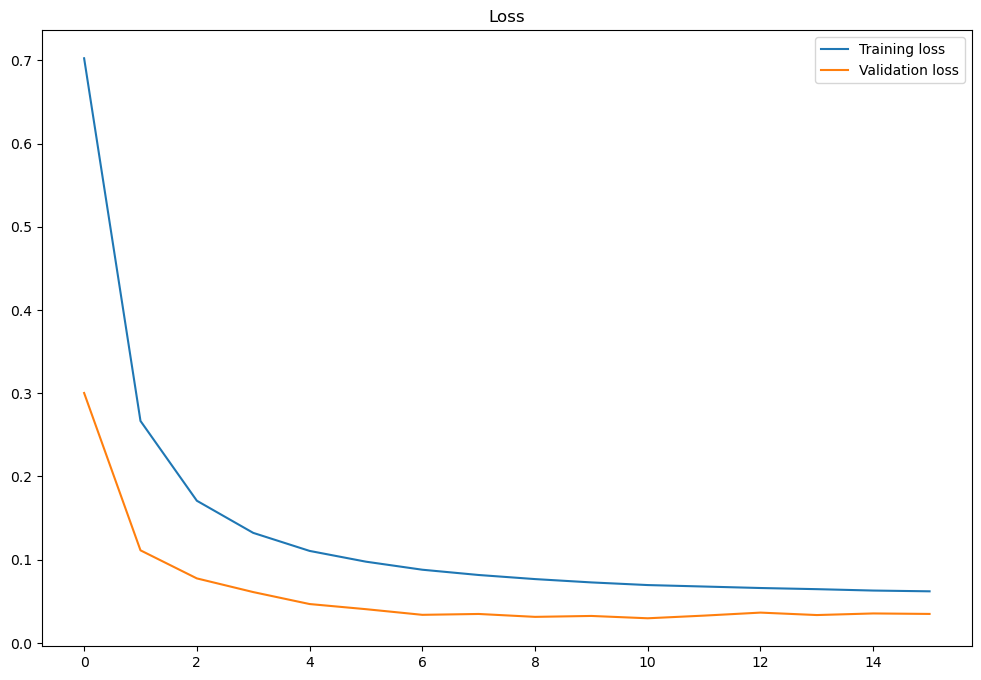

In [14]:
plt.title('Loss')
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

### Reconstruction

In [15]:
train_pred = model.predict(train_data)
test_pred = model.predict(test_data)

160/160 [==============================] - 3s 21ms/step


In [16]:
train_loss = []
for i in range(len(train_data)):
    err = mean_squared_error(train_data[i],train_pred[i])
    train_loss.append(err)
    
test_loss = []
for i in range(len(test_data)):
    err = mean_squared_error(test_data[i],test_pred[i])
    test_loss.append(err)

#### Train MSE Loss

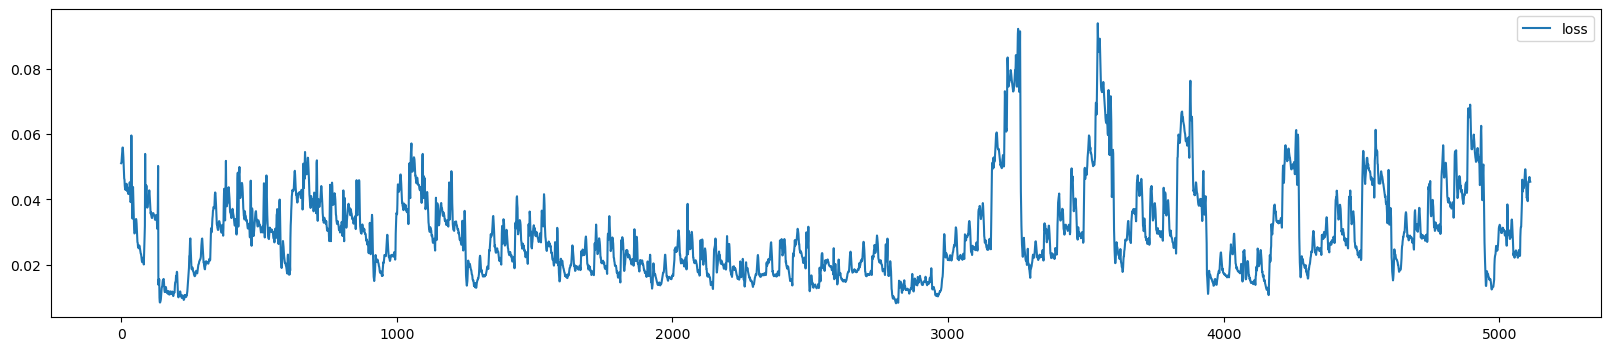

In [17]:
plt.figure(figsize=(20,4))
plt.plot(train_loss, label='loss')
plt.legend()
plt.show()

#### Test MSE Loss and Anomalies

To identify anomalies, we set a threshold of [mean of loss + 2*standard deviation]. 


In [46]:
threshold = np.mean(test_loss)+3*np.std(test_loss)

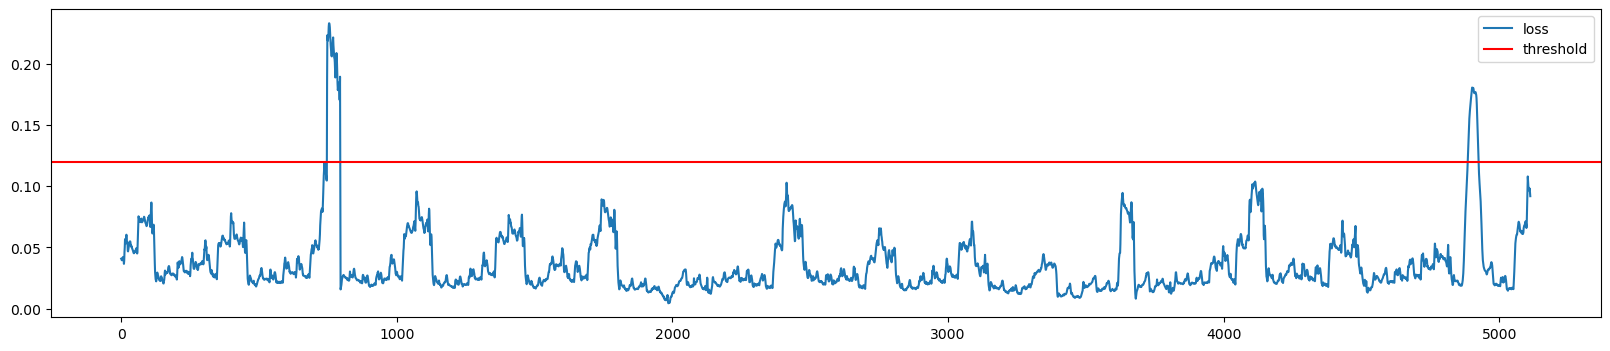

In [47]:
plt.figure(figsize=(20,4))
plt.plot(test_loss, label='loss')
plt.axhline(threshold, color='red', label='threshold')
plt.legend()
plt.show()

## Finding the anomaly dates

In [48]:
test_dates = df[train_size:].index
anomaly_dates = test_dates[:-47][test_loss > threshold]

In [52]:
print(anomaly_dates)

DatetimeIndex(['2014-11-01 01:30:00', '2014-11-01 02:00:00',
               '2014-11-01 02:30:00', '2014-11-01 03:00:00',
               '2014-11-01 03:30:00', '2014-11-01 04:00:00',
               '2014-11-01 04:30:00', '2014-11-01 05:00:00',
               '2014-11-01 05:30:00', '2014-11-01 06:00:00',
               '2014-11-01 06:30:00', '2014-11-01 07:00:00',
               '2014-11-01 07:30:00', '2014-11-01 08:00:00',
               '2014-11-01 08:30:00', '2014-11-01 09:00:00',
               '2014-11-01 09:30:00', '2014-11-01 10:00:00',
               '2014-11-01 10:30:00', '2014-11-01 11:00:00',
               '2014-11-01 11:30:00', '2014-11-01 12:00:00',
               '2014-11-01 12:30:00', '2014-11-01 13:00:00',
               '2014-11-01 13:30:00', '2014-11-01 14:00:00',
               '2014-11-01 14:30:00', '2014-11-01 15:00:00',
               '2014-11-01 15:30:00', '2014-11-01 16:00:00',
               '2014-11-01 16:30:00', '2014-11-01 17:00:00',
               '2014-11-

Our model has identified anomalies in the time periods '2014-11-01 to 2014-11-02' and '2015-01-26 to 2015-01-27'. These anomalies correspond to specific events in New York City:
* The NYC Marathon on November 2, 2014
* The January 2015 North American blizzard on January 26 and 27, 2015
The model has detected these periods as anomalous because they deviate significantly from the expected patterns of the time series data, as determined by the mean and standard deviation of the loss values. 

## Conclusion

In this final project, we conducted an unsupervised analysis of NYC taxi traffic using the LSTM autoencoder anomaly detection method. Our analysis identified anomalous time periods, including the NYC Marathon and the January 2015 North American blizzard, that deviated significantly from the expected patterns in the time series data.

We found the LSTM autoencoder method to be a useful tool for detecting anomalies in time series data without the need for labeled training data. By using a deep learning approach, we were able to capture complex patterns and relationships in the data that traditional statistical methods may have missed.

Overall, our analysis demonstrates the potential of LSTM autoencoder anomaly detection for monitoring and identifying unexpected events or patterns in time series data. This approach could be useful in a variety of fields, from finance and economics to healthcare and transportation, where the ability to detect anomalies in large datasets is critical for decision-making and risk management.